# Анализ тарифов оператора сотовой связи


## Проблемы и задачи

«Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Задача - сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## **Загрузка данных и библиотек**

In [6]:
# импортируем задействованные библиотеки
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import datetime as dt
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [7]:
# Зададим параметры отображения значений и графиков
plt.style.use('seaborn')

In [8]:
# загружаем данные
try:
    calls = pd.read_csv('./Data/calls.csv')
    internet = pd.read_csv('./Data/internet.csv', index_col=0)
    messages = pd.read_csv('./Data/messages.csv')
    tariffs = pd.read_csv('./Data/tariffs.csv')
    users = pd.read_csv('./Data/users.csv')
except:
    calls = pd.read_csv('/datasets/calls.csv')
    internet = pd.read_csv('/datasets/internet.csv', index_col=0)
    messages = pd.read_csv('/datasets/messages.csv')
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    users = pd.read_csv('/datasets/users.csv')

### Описание данных

Таблица users (информация о пользователях):

- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана

Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## **Подготовка данных**

In [9]:
# посмотрим на структуру данных в таблицах
for df in [users, calls, messages, internet, tariffs]:
    print(df.info())
    print('_' * 45)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None
_____________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2

In [10]:
# сразу поправим имена столбцов в таблице с тарифами
tariffs = tariffs.rename(columns={'tariff_name': 'tariff', 
                                  'rub_monthly_fee': 'fixed_fee',
                                  'mg_per_month_included': 'mb_per_month_included',
                                 })

<div style="border:solid #8B008B 1px; padding: 20px">

Приведем данные к единообразному виду:
- колонки с датами приведем к формату даты
- округлим минуты большую сторону

In [11]:
# приведем колонки с датами к формату даты
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
calls['duration'] = calls['duration'].apply(np.ceil).astype('int32')

In [12]:
# постмотрим на статиситики числовых переменных в таблицах
for df in [users, calls, messages, internet]:
    print(df.describe())
    print('_' * 45)

           user_id        age
count   500.000000  500.00000
mean   1249.500000   46.58800
std     144.481833   16.66763
min    1000.000000   18.00000
25%    1124.750000   32.00000
50%    1249.500000   46.00000
75%    1374.250000   62.00000
max    1499.000000   75.00000
_____________________________________________
            duration        user_id
count  202607.000000  202607.000000
mean        7.158198    1253.940619
std         5.959173     144.722751
min         0.000000    1000.000000
25%         2.000000    1126.000000
50%         6.000000    1260.000000
75%        11.000000    1379.000000
max        38.000000    1499.000000
_____________________________________________
             user_id
count  123036.000000
mean     1256.989410
std       143.523967
min      1000.000000
25%      1134.000000
50%      1271.000000
75%      1381.000000
max      1499.000000
_____________________________________________
             mb_used        user_id
count  149396.000000  149396.000000
mean   

<div style="border:solid #9ACD32 2px; padding: 20px">
Значения переменных находятся в рамках разумных значений.

In [13]:
# рассчитаем ежемесячное количество тарифицируемых едениц звонков по клиентам 
calls_month = calls.groupby(['user_id', calls['call_date']
                             .dt.month])['duration'].agg([('num_calls', 'count'), ('duration', 'sum')]).reset_index()
calls_month = calls_month.rename(columns={'call_date': 'month'})
calls_month.shape

(3174, 4)

In [14]:
# рассчитаем ежемесячное количество сообщений по клиентам
sms_month = messages.groupby(['user_id', messages['message_date']
                              .dt.month])['message_date'].agg([('messages', 'count')]).reset_index()
sms_month = sms_month.rename(columns={'message_date': 'month'})
sms_month.shape

(2717, 3)

In [15]:
# рассчитаем ежемесячный интернет траффик по клиентам, округленный вверх до целых Гб
gb_month = internet.groupby(['user_id', internet['session_date'] \
                             .dt.month])['mb_used'].agg([('traffic', 'sum')]) \
                             .apply(lambda x: np.ceil(x / 1024)) \
                             .astype('int32').reset_index()
gb_month = gb_month.rename(columns={'session_date': 'month'})
gb_month.shape

(3203, 3)

In [16]:
# объединим все месячные данные по клиентам в одну таблицу с активностями
activity = pd.merge(calls_month, sms_month, on=['user_id', 'month'], how='outer')
activity = activity.merge(gb_month, on=['user_id', 'month'], how='outer')

In [17]:
activity = activity.fillna(0)
activity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    3214 non-null   int64  
 1   month      3214 non-null   int64  
 2   num_calls  3214 non-null   float64
 3   duration   3214 non-null   float64
 4   messages   3214 non-null   float64
 5   traffic    3214 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 175.8 KB


In [18]:
# объединим все данные по активности с базой клиентов и тарифов
df = activity.merge(users, how='left', on='user_id' ).merge(tariffs, on='tariff', how='left')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   int64         
 2   num_calls              3214 non-null   float64       
 3   duration               3214 non-null   float64       
 4   messages               3214 non-null   float64       
 5   traffic                3214 non-null   float64       
 6   age                    3214 non-null   int64         
 7   churn_date             187 non-null    datetime64[ns]
 8   city                   3214 non-null   object        
 9   first_name             3214 non-null   object        
 10  last_name              3214 non-null   object        
 11  reg_date               3214 non-null   datetime64[ns]
 12  tariff                 3214 non-null   object        
 13  mes

In [20]:
# переведем переменные в целочисленный формат
for col in df.select_dtypes(include=np.number).columns[1:]:
    df[col] = df[col].astype('int32')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   int32         
 2   num_calls              3214 non-null   int32         
 3   duration               3214 non-null   int32         
 4   messages               3214 non-null   int32         
 5   traffic                3214 non-null   int32         
 6   age                    3214 non-null   int32         
 7   churn_date             187 non-null    datetime64[ns]
 8   city                   3214 non-null   object        
 9   first_name             3214 non-null   object        
 10  last_name              3214 non-null   object        
 11  reg_date               3214 non-null   datetime64[ns]
 12  tariff                 3214 non-null   object        
 13  mes

Добавим в таблицу данные о выручке, которую приносит клиент, исходя из действующего тарифа и объема потребленных услуг.

In [22]:
# функция variable_fee() рассчитывает плату, которую должен внести клиент, исходя из его тарифа 
# и фактического объема потребленных услуг
def variable_fee(df):
    minutes_excess = (df['duration'] - df['minutes_included']) * df['rub_per_minute']
    sms_excess = (df['messages'] - df['messages_included']) * df['rub_per_message']
    int_excess = (df['traffic'] - df['mb_per_month_included'] / 1024) * df['rub_per_gb']
    res = [x if x > 0 else 0 for x in [minutes_excess, sms_excess, int_excess]]
    return sum(res)

In [23]:
# добавим в общую таблицу переменную плату по тарифу и общий платеж
df['var_fee'] = df.apply(variable_fee, axis=1)
df['total_fee'] = df['fixed_fee'] + df['var_fee']

Выведем итоговую таблицу

In [24]:
df.sample(4)

,user_id,month,num_calls,duration,messages,traffic,age,churn_date,city,first_name,...,tariff,messages_included,mb_per_month_included,minutes_included,fixed_fee,rub_per_gb,rub_per_message,rub_per_minute,var_fee,total_fee
2611,1411,12,108,793,91,15,36,NaT,Грозный,Берта,...,smart,50,15360,500,550,200,3,3,1002.0,1552.0
1158,1183,10,63,421,31,12,20,NaT,Владивосток,Снежана,...,smart,50,15360,500,550,200,3,3,0.0,550.0
2982,1468,11,36,276,13,13,29,NaT,Тамбов,Иван,...,smart,50,15360,500,550,200,3,3,0.0,550.0
3174,1091,5,0,0,30,11,36,NaT,Набережные Челны,Вера,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   int32         
 2   num_calls              3214 non-null   int32         
 3   duration               3214 non-null   int32         
 4   messages               3214 non-null   int32         
 5   traffic                3214 non-null   int32         
 6   age                    3214 non-null   int32         
 7   churn_date             187 non-null    datetime64[ns]
 8   city                   3214 non-null   object        
 9   first_name             3214 non-null   object        
 10  last_name              3214 non-null   object        
 11  reg_date               3214 non-null   datetime64[ns]
 12  tariff                 3214 non-null   object        
 13  mes

<div style="border:solid #9ACD32 2px; padding: 20px">

### Результаты предварительной подготовки
В предоставленных для анализа данных имеется информация о 500 клиентах оператора связи, а также объеме потребленных ими телекоммуникационных услуг за 12 месяцев 2018 года.

Мы привели колонки с датами к формату даты, сгруппировали данные в разных таблицах помесячно и объединили все переменные в один датафрейм, а также

- рассчитали объем и стоимость потребленных каждым клиентом услуг, исходя из действующих тарифов
- привели основные переменные к целочисленному типу

## **Разведывательный анализ данных**

### Общие показатели выручки

<div style="border:solid #8B008B 1px; padding: 10px">

Взглянем какую выручку приносят представленные в выборке абоненты.

In [26]:
# создадим группировку выручки по тарифам и месяцам
rev_by_tariff = df.groupby(['tariff', 'month'])['total_fee'].agg(['count', 'sum'])

In [27]:
# выведем распределение выручки на графике
# создаем фигуру с дополнительной правой осью
fig = make_subplots(specs=[[{"secondary_y": True}]])
# добавляем бары с выручкой
fig.add_trace(go.Bar(x = rev_by_tariff.loc['ultra'].index,
            y = rev_by_tariff.loc['ultra']['sum'],
            name = 'Выручка Ultra', marker = dict(color='#46C8DC')),
            secondary_y=False)

fig.add_trace(go.Bar(x = rev_by_tariff.loc['smart'].index,
            y = rev_by_tariff.loc['smart']['sum'],
            name = 'Выручка Smart', marker = dict(color='#326496')),
            secondary_y=False)
# добавляем линию с количеством абонентов на тарифе Ultra
fig.add_trace(go.Scatter(x = df[df.tariff == 'ultra'].groupby('month')['user_id'].agg(['count']).index,
            y = df[df.tariff == 'ultra'].groupby('month')['user_id'].count(),
            name = 'Абоненты Ultra',
            mode='lines',
            marker = dict(color='#9A3F50'),
            ), secondary_y=True)
# добавляем линию с количеством абонентов на тарифе Smart
fig.add_trace(go.Scatter(x = df[df.tariff == 'smart'].groupby('month')['user_id'].agg(['count']).index,
            y = df[df.tariff == 'smart'].groupby('month')['user_id'].count(),
            name = 'Абоненты Smart',
            mode='lines',
            marker = dict(color='tomato'),
            ), secondary_y=True)
# настраиваем макет
fig.update_layout(barmode='stack',
                  title='<b>Динамика выручки и числа абонентов</b>',
                  height=450, width=600,
                  plot_bgcolor='#E2EDF3',
                  margin=dict(l=0, b=20, t=40))

fig.update_layout(legend=dict(
    orientation="v",
    yanchor="top", y=0.99,
    xanchor="left", x=0.01,
    bgcolor='#E7F2F8',
    bordercolor='#9A3F50',
    borderwidth=1,
    font_size=11
))

# форматируем оси
fig.update_xaxes(title={'text': 'Месяцы'}, title_font_size=14, gridcolor='Gainsboro')
fig.update_yaxes(title_text='Выручка (₽ млн.)',  secondary_y=False)
fig.update_yaxes(title_text='Число абонентов', secondary_y=True, gridcolor='Gainsboro')
fig.show()

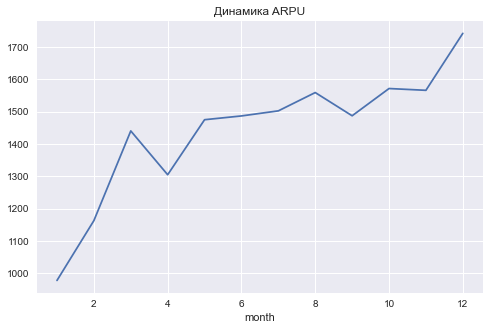

In [28]:
# переменная средней выручки на абонента помесячно
arpu_month = df.groupby(['month'])['total_fee'].sum() / df.groupby(['month'])['total_fee'].count()
_ = arpu_month.plot(title='Динамика ARPU', figsize=(8, 5))

<div style="border:solid #9ACD32 2px; padding: 20px">
На протяжении всего периода количество абонентов на двух тарифах росло примерно одинаковыми темпами.


Выручка увеличивалась пропорционально росту количества активных пользователей, причем основной прирост выручки дали абоненты, находящиеся на тарифе Smart.

Таким образом, рост выручки обусловлен как ростом абонентской базы, так и существенным увеличением ARPU (Average revenue per user) - средней выручки на абонента.

### Анализ потребления услуг

<div style="border:solid #8B008B 1px; padding: 10px">

Изучим как распределяются месячные объемы потребляемых услуг у клиентов с учетом выбранного тарифного плана. В нашей выборке 1915 значений абонент-месяц для тарифа Smart и 752 значения для тарифа Ultra.

Для анализа сделаем выборки значений выручки в зависимости от тарифа.

Дополнительно полезно будет оценить как потребляют услуги абоненты разных возрастов. Для этого категоризируем данные о возрасте, например, присвоив клиентам принадлежность к тому или иному поколению.

В нашей базе возраст клиентов находится в диапазоне от 18 до 75 лет. Воспользуемся [популярной классификацией](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B8%D1%8F_%D0%BF%D0%BE%D0%BA%D0%BE%D0%BB%D0%B5%D0%BD%D0%B8%D0%B9) поколений, которая часто используется в маркетинге.
Учитывая, что мы работаем с данными за 2018, получим следующее распределение возрастов по поколениям:

- бэби-бумеры (ВВ) - старше 55 лет
- поколение X (X) - 37-55 лет
- поколение Y или миллениалы (Y) - младше 37 лет

Представители поколения Z в выборке пока еще не были представлены.


In [29]:
# ряд значений выручки по абонентам тарифа Smart
rev_smart = df[df['tariff'] == 'smart']['total_fee']
# ряд значений выручки по абонентам тарифа Ultra
rev_ultra = df[df['tariff'] == 'ultra']['total_fee']
print('Число значений абонент-месяц для тарифов Smart и Ultra:', [len(rev_smart), len(rev_ultra)])

# разобьем абонентов на 3 категории в зависимости от возраста
df['gen'] = pd.cut(df.age, [0, 36, 55, np.inf], labels=['Y', 'X', 'BB'])
print('Выручка в разрезе поколений')
df.groupby('gen')[['total_fee']].agg(['sum', 'count', 'mean', 'std'])

Число значений абонент-месяц для тарифов Smart и Ultra: [2229, 985]
Выручка в разрезе поколений


total_fee                               
           sum count         mean         std
gen                                          
Y    1550745.0   986  1572.763692  825.182015
X    1721884.0  1147  1501.206626  828.115295
BB   1641822.0  1081  1518.799260  737.765983

<div style="border:solid #8B008B 1px; padding: 10px">

Посчитаем основные статистики потребления услуг и выручки и выведем их на графиках.

In [30]:
print('Основные статистики переменных в разрезе тарифов')
(
df.groupby('tariff')[['num_calls', 'duration', 'messages', 'traffic', 'var_fee', 'total_fee']]
     .agg(['mean', 'var', 'std'])
) 

Основные статистики переменных в разрезе тарифов


num_calls                            duration                 \
             mean          var        std        mean            var   
tariff                                                                 
smart   58.463437   672.876243  25.939858  417.934948   36219.315784   
ultra   73.392893  1928.689990  43.916853  526.623350  100873.633397   

                     messages                            traffic             \
               std       mean          var        std       mean        var   
tariff                                                                        
smart   190.313730  33.384029   796.812958  28.227876  16.328847  33.028705   
ultra   317.606098  49.363452  2285.266143  47.804457  19.494416  97.091686   

                     var_fee                               total_fee  \
             std        mean            var         std         mean   
tariff                                                                 
smart   5.747061  739.973531  669785.708006  818.404367  1289.973531   
ultra   9.853511  120.152284  141516.745079  376.187114  2070.152284   

                                   
                  var         std  
tariff                             
smart   669785.708006  818.404367  
ultra   141516.745079  376.187114

In [31]:
# функция overlay_hist() строит гистограмму распределения переменной 
# с разбивкой между двумя тарифами
def overlay_hist(trace_1, trace_2, title, title2='Распределение значений', y1_name='Частота', legend=True):
    fig = make_subplots(1,2, column_widths=[2, 1],
                        column_titles=[title, title2]
                        )
    # добавляем на фигуру гистограммы
    fig.add_trace(go.Histogram(
        x = trace_1,
        nbinsx=50,
        name = 'Smart',
        opacity = 1,
        marker = dict(color='#326496',
        line=dict(color = "LightGray", width = 1))),
        row=1, col=1
    )
    fig.add_trace(go.Histogram(
        x = trace_2,
        nbinsx=50,
        name = 'Ultra',
        opacity = 0.7,
        marker = dict(color='#46C8DC',
        line=dict(color = "LightGray", width = 1))),
        row=1, col=1
    )
    # добавляем линии среднего и медианы
    fig.add_vline(x=trace_1.median(), line_dash='dash', 
              line_color = 'tomato', line_width=3,
              annotation_text=f'median = {trace_1.median():.0f}', annotation_position="top left")
    fig.add_vline(x=trace_1.mean(), line_dash='dash', 
              line_color = '#B494A0', line_width=3,
              annotation_text=f'mean = {trace_1.mean():.0f}', annotation_position="top right")
    
    fig.add_trace(go.Box(y=trace_1, marker_color='#A0D6B4', name='Вся выборка'),
                  row=1, col=2
                  )
    # параметры фигуры (#E1F0F5)
    fig.update_layout(
                    # title = title,
                    # legend_orientation="h", 
                    showlegend=legend, 
                    title_x = 0.1,
                    # yaxis_title = 'Частота',
                    # xaxis_title = 'Значение параметра',
                    # legend_title = 'Тариф:',
                    barmode='overlay',
                    height = 450, width=900,
                    plot_bgcolor='#E2EDF3',
                    margin=dict(l=0, b=50, t=40)
                    
                    )
    fig.update_layout(  legend=dict(
                        orientation="v",
                        yanchor="top", y=0.99,
                        xanchor="right", x=0.59,
                        bgcolor='#E7F2F8',
                        bordercolor='#9A3F50',
#                         title = '<b>Тариф:</b>',
#                         title_font_size=11,
                        borderwidth=1,
                        font_size=11
                    ))
    
    fig.update_xaxes(gridcolor='Gainsboro')
    fig.update_yaxes(title=y1_name, gridcolor='LightGray', row=1, col=1)
    fig.update_yaxes(title_text=title, row=1, col=2)
    fig.show()

In [32]:
# выведем гистограммы потребления услуг
overlay_hist(df['num_calls'], df[df['tariff'] == 'ultra']['num_calls'], 'Количество звонков')
overlay_hist(df['duration'], df[df['tariff'] == 'ultra']['duration'], 'Длительность звонков в минутах')

In [33]:
overlay_hist(df['messages'], df[df['tariff'] == 'ultra']['messages'], 'Количество sms')
overlay_hist(df['traffic'], df[df['tariff'] == 'ultra']['traffic'], 'Интернет траффик в гигабайтах')

In [34]:
fig = px.scatter(
    data_frame=df, 
    x="duration", 
    y="traffic", 
    facet_col="tariff",
    height=500, width=900,
    template='ggplot2'
        
)
fig.layout.title='Длительность звонков и интернет-траффик'
fig.show()

<div style="border:solid #9ACD32 2px; padding: 20px">

Из гистограмм мы видим, что разброс значений потребленных услуг в целом близок к нормальному. Средние значения в большинстве случаев делят выборку пополам, т.е. практически совпадают с медианой.

Распределения количества и длительности звонков очень похожи, что говорит о малой вариативности средней длительности разговора. 

На тарифе Smart видна прямая зависимость между объемами потребления разных услуг. Например, люди, которые больше разговаривают, также активнее потребляют интернет траффик. У пользователей тарифа Ultra такой зависимости не наблюдается.

В среднем абоненты с тарифом Smart ежемесячно совершают 58 звонков, отправляют 39 смс, проводят 421 минуту в разговорах и загружают около 16 Гб данных из интернета.

Те же показатели для абонентов с тарифом Ultra выглядят следующим образом: 78 звонков, 312 смс, 557 минут и 47 Гб интернет-траффика.

Таким образом, абоненты на тарифе Ultra потребляют услуги более активно, но, как правило, укладываются в установленные тарифом пакеты.





### Анализ доходности разных тарифов

<div style="border:solid #8B008B 1px; padding: 10px">

Введем статистики выручки на разных тарифах.

In [35]:
# гистограммы выручки на разных тарифах
overlay_hist(rev_smart, None, 'Выручка с абонента тарифа Smart')
overlay_hist(rev_ultra, None, 'Выручка с абонента тарифа Ultra')

In [36]:
fig = px.histogram(df, x='var_fee', facet_col='tariff', 
                   title='Выручка от допуслуг на разных тарифах',
                   color_discrete_sequence=['#326496', '#42C8CD', '#9A3F50'])
fig.update_layout(plot_bgcolor='#E2EDF3',
                  height = 500, width=900)
fig.update_xaxes(gridcolor='Gainsboro')
fig.show()

<div style="border:solid #9ACD32 2px; padding: 20px">

Распределение выручки на тарифе Smart близко к нормальному со средним значением 1290 и медианой 1023 руб. в месяц.

Распределение выручки на тарифе Ultra фактически представляет собой константу - почти все значения равны абонентской плате (1950 руб.) с небольшим количеством превышающих эту величину значений. Среднее, соответственно, равно 2049 руб. в месяц.

Таким образом, несмотря на то, что абоненты Ultra потребляют больше услуг, платят они в среднем в 1.8 раза меньше, чем абоненты Smart.

<div style="border:solid #8B008B 1px; padding: 10px">

Посмотрим влияет ли гендерный фактор на доходность абонентов.

In [37]:
fig = px.scatter(df, x='traffic', y='total_fee', color='gen', facet_col='tariff', 
                   title='Потребление допуслуг на разных тарифах в разрезе поколений',
                   color_discrete_sequence=['#326496', '#42C8CD', '#A0D6B4'])
fig.update_layout(plot_bgcolor='#E2EDF3',
                  height = 500, width=900)
fig.show()

<div style="border:solid #9ACD32 2px; padding: 20px">

Мы проверили как связаны выручки и потребление различных услуг. К повышенной выручки с абонентов, главным образом, имеет отношение превышение потребления интернет трафика сверх предоставляемого по тарифу (см. график).

Отличий в поведении абонентов разных возрастов не выявлено - все поколения пользуются услугами примерно одинаково, об этом говорят и одинаковые средние значения и стандарнтные отклонения по группам. И это довольно неожиданно.

### Доходы по регионам

<div style="border:solid #8B008B 1px; padding: 10px">

Проверим как связано месторасположение абонента с выручкой оператора.

In [38]:
overlay_hist(df[df['city'] == 'Москва']['total_fee'], None, 'Выручка абонентов Москвы', legend=False)
overlay_hist(df[df['city'] != 'Москва']['total_fee'], None, 'Выручка абонентов регионов', legend=False)

In [39]:
# создадим группировку выручки по городам
rev_by_city = df.groupby(by=['city'])['total_fee'].agg(['count', 'sum']).sort_values(by='sum', ascending=False).reset_index()
# добавим переменную ARPU - Average revenue per user
rev_by_city['arpu'] = (rev_by_city['sum'] / rev_by_city['count']).astype('int32')

In [40]:
rev_by_city

,city,count,sum,arpu
0,Москва,611,945042.0,1546
1,Санкт-Петербург,270,436982.0,1618
2,Новосибирск,98,174542.0,1781
3,Уфа,95,145762.0,1534
4,Краснодар,86,132790.0,1544
...,...,...,...,...
71,Кемерово,5,9165.0,1833
72,Владикавказ,7,8985.0,1283
73,Волжский,7,6050.0,864
74,Иваново,2,3900.0,1950


In [41]:
print('Топ 10 городов с максимальной выручкой на абонента:')
rev_by_city.sort_values(by='arpu', ascending=False)[:15]

Топ 10 городов с максимальной выручкой на абонента:


,city,count,sum,arpu
14,Воронеж,39,89553.0,2296
29,Саранск,22,47893.0,2176
47,Череповец,14,29637.0,2116
49,Оренбург,13,26769.0,2059
21,Брянск,28,56850.0,2030
37,Чебоксары,20,39914.0,1995
26,Мурманск,25,49613.0,1984
67,Нижневартовск,6,11700.0,1950
66,Сургут,6,11700.0,1950
74,Иваново,2,3900.0,1950


In [42]:
# сгруппируем для графика города, не попавшие в топ-15 по выручке 
rev_by_city["ranked"] = np.where(rev_by_city['sum'].rank(ascending=False) <= 15, rev_by_city['city'], "Прочие")
# создадим переменную для визуализации со средним доходом от одного абонента по ранжированным городам
arpu_by_city = rev_by_city.groupby('ranked')['arpu'].mean().sort_values(ascending=False).reset_index()

In [43]:
print('Показатели 15 крупнейших региональных рынков')
fig = make_subplots(1,2, subplot_titles = ['Совокупная выручка по городам', 'Средняя выручка на одного пользователя'])
# добавляем бары с выручкой
fig.add_trace(go.Bar(x = rev_by_city['ranked'],
            y = rev_by_city['sum'],
            marker = dict(color='#326496')),
            row=1, col=1
            )

fig.add_trace(go.Bar(x = arpu_by_city['ranked'],
            y = arpu_by_city['arpu'],
            marker = dict(color='#326496')),
            row=1, col=2
            )
fig.update_layout(  showlegend=False,
                    title_x = 0.1,
                    yaxis_title = 'Выручка (₽ млн.)',
                    # barmode='overlay',
                    height = 450, width=900,
                    plot_bgcolor='#E2EDF3',
                    margin=dict(l=0, b=50, t=40)
                    
                    )
fig.update_xaxes(gridcolor='Gainsboro')
fig.update_yaxes(gridcolor='LightGray')
fig.update_yaxes(title_text='Доход с абонента, ₽')
fig.show()

Показатели 15 крупнейших региональных рынков


<div style="border:solid #9ACD32 2px; padding: 20px">

Москва является крупнейшим рынком по совокупной выручке и количеству абонентов. Однако по выручке на одного 
абонента Москва находится в конце списка 15 крупнейших региональных рынков.

Пятерку наиболее доходных по показателю ARPU регионов составляют Оренбург, Мурманск, Чебоксары, Севастополь и Петрозаводск.

## **Проверка гипотез**

Выдвинем и проведем статистическую проверку нескольких гипотез касательно имеющихся выборочных данных.

<div style="border:solid #8B008B 1px; padding: 10px">

### Гипотеза о равенстве средней выручки на разных тарифах

**Гипотеза Н0** - средняя выручка пользователей тарифов Smart и Ultra не различается

**Альтернативная гипотеза Н1** - средняя выручка на тарифе Smart отличается от выручки на тарифе Ultra (двусторонний тест)

Откорректируем наши выборки по выручке на разных тарифах, удалив выбросы (порог - 1% верхних значений), и применим статтест на основе критерия Стьюдента.

In [44]:
rev_smart_filtered = rev_smart[rev_smart.values < np.quantile(rev_smart.values, 0.99)]
rev_ultra_filtered = rev_ultra[rev_ultra.values < np.quantile(rev_ultra.values, 0.99)]

In [45]:
print(rev_smart_filtered.var())
print(rev_ultra_filtered.var())

552605.2505981406
98739.14073606173


<div style="border:solid #8B008B 1px; padding: 10px">

В качестве порогового значения p-value выберем 5%.

Дисперсии выборок отличаются в несколько раз, поэтому параметр equal_var установим как False.

In [46]:
alpha = 0.05
 
 
results = st.ttest_ind(rev_smart_filtered, rev_ultra_filtered, equal_var=False)
 
print('p-значение: ', results.pvalue)
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу") 

p-значение:  5.222800864097e-311
Отвергаем нулевую гипотезу


<div style="border:solid #9ACD32 2px; padding: 20px">

Статтест не подтвердил равенство средних двух выборок при заданном уровне значимости, следовательно нам следует отклонить нулевую гипотезу в пользу альтернативной, т.е. ***средняя выручка на разных тарифах различается***.

<div style="border:solid #8B008B 1px; padding: 10px">

### Гипотеза о равенстве средней выручки в Москве и регионах

**Гипотеза Н0** - средняя выручка абонентов их Москвы и других регионов не различается

**Альтернативная гипотеза Н1** - средняя выручка московских абонентов отличается от выручки немосковских абонентов (двусторонний тест)

Создадим выборки по выручке в Москве и регионах, удалим выбросы (порог - 1% верхних значений) и применим статтест на основе критерия Стьюдента.

In [47]:
rev_moscow = df[df['city'] == 'Москва']['total_fee']
rev_region = df[df['city'] != 'Москва']['total_fee']

In [48]:
print(rev_moscow.var())
print(rev_region.var())

565636.4670118855
654137.6285218047


<div style="border:solid #8B008B 1px; padding: 10px">

В качестве порогового значения p-value выберем 5%.

Дисперсии выборок отличаются не так значительно, поэтому параметр equal_var установим как True.

In [49]:
alpha = 0.05
 
 
results = st.ttest_ind(rev_moscow, rev_region, equal_var=False)
 
print('p-значение: ', results.pvalue)
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу") 

p-значение:  0.5257376663729298
Не отвергаем нулевую гипотезу


<div style="border:solid #9ACD32 2px; padding: 20px">


Статтест подтвердил равенство средних двух выборок при заданном уровне значимости, следовательно нам не следует отклонять нулевую гипотезу в пользу альтернативной, т.е. ***средняя выручка абонентов в Москве и регионах статистически не различается***.

## **Выводы по проекту**

Мы проанализировали данные о выборке абонентов сотового оператора.

В ходе анализа были изучены объемы потребления услуг сотового оператора различными группами абонентов в разрезе тарифов, регионов и возрастов. 

Мы проверили гипотезы о равенстве средних значений выручки абонентов 

* на двух тарифах 
* в Москве и регионах

По результатам статистических тестов мы пришли к выводу о различии в доходности абонентов, использующих разные тарифы, а также между абонентами Москвы и других регионов. 

Отвечая на поставленный в задаче вопрос, отметим, что для оператора тариф Ultra более прибылен, в то время как для абонентов выгоднее находится на тарифе Smart. 
